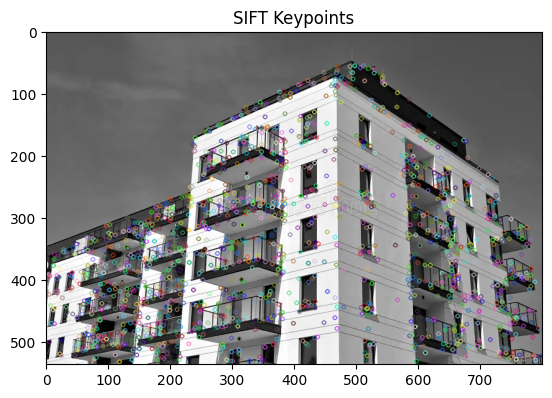

In [ ]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('/content/pic 1.webp', cv2.IMREAD_GRAYSCALE)
sift = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(img, None)
img_sift = cv2.drawKeypoints(img, keypoints, None)

plt.imshow(img_sift)
plt.title("SIFT Keypoints")
plt.show()


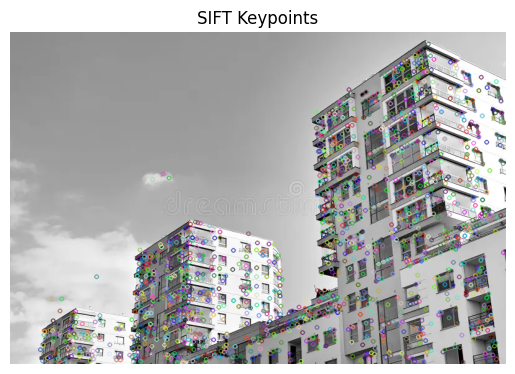

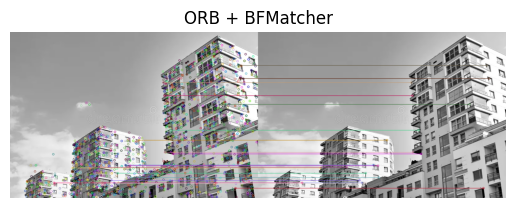

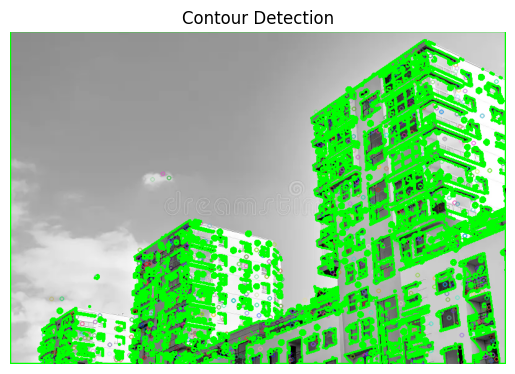

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the uploaded images
img1 = cv2.imread('/content/pic 2.webp')  # Replace with your actual image name
img2 = cv2.imread('/content/pic 2.webp')  # Replace with your actual image name

# Convert to grayscale
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# === SIFT ===
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

img_sift = cv2.drawKeypoints(gray1, kp1, img1)
plt.imshow(cv2.cvtColor(img_sift, cv2.COLOR_BGR2RGB))
plt.title("SIFT Keypoints")
plt.axis('off')
plt.show()

# === ORB + BFMatcher ===
orb = cv2.ORB_create()
kp3, des3 = orb.detectAndCompute(gray1, None)
kp4, des4 = orb.detectAndCompute(gray2, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des3, des4)
matches = sorted(matches, key=lambda x: x.distance)

img_matches = cv2.drawMatches(img1, kp3, img2, kp4, matches[:20], None, flags=2)
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.title("ORB + BFMatcher")
plt.axis('off')
plt.show()

# === Contour Detection ===
gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

img_contours = img1.copy()
cv2.drawContours(img_contours, contours, -1, (0,255,0), 2)

plt.imshow(cv2.cvtColor(img_contours, cv2.COLOR_BGR2RGB))
plt.title("Contour Detection")
plt.axis('off')
plt.show()


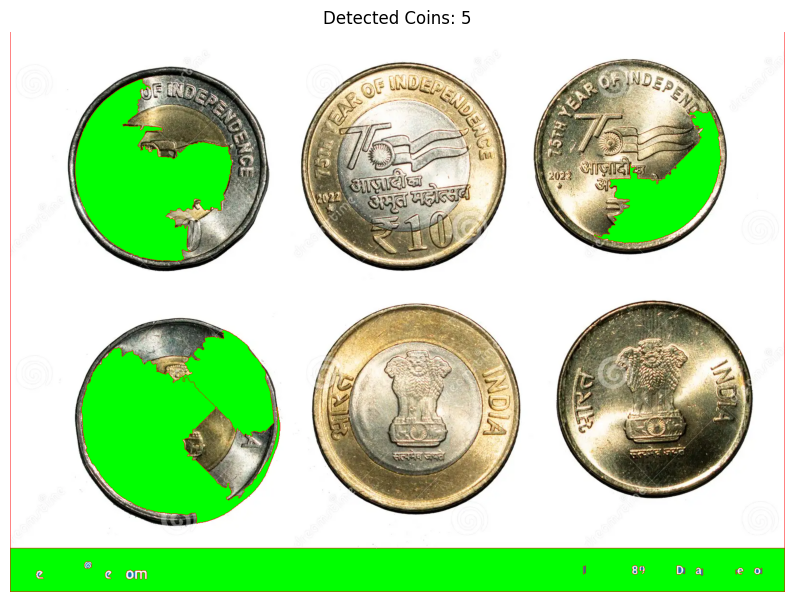

Number of coins detected: 5


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
img = cv2.imread('/content/pic 4.webp')
if img is None:
    raise ValueError("Image not found or path is incorrect.")

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Preprocessing: smooth image
gray = cv2.medianBlur(gray, 5)
blur = cv2.GaussianBlur(gray, (7, 7), 0)

# Thresholding using Otsu's method
ret, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Morphological opening to remove small noise
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Sure background area via dilation
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Sure foreground area using distance transform
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.6 * dist_transform.max(), 255, 0)  # Increased from 0.2 to 0.6
sure_fg = np.uint8(sure_fg)

# Unknown region = background - foreground
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labeling
ret, markers = cv2.connectedComponents(sure_fg)

# Add 1 to all labels so background is not 0, and mark unknown as 0
markers = markers + 1
markers[unknown == 255] = 0

# Apply watershed
markers = cv2.watershed(img, markers)

# Draw boundaries and fill detected coins
result = img.copy()
result[markers == -1] = [0, 0, 255]  # Boundary in red
result[markers > 1] = [0, 255, 0]    # Coins in green

# Filter unique labels, ignoring background (1) and boundary (-1)
unique_labels = np.unique(markers)
coin_labels = [label for label in unique_labels if label > 1]

# Display result
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title(f"Detected Coins: {len(coin_labels)}")
plt.axis('off')
plt.show()

print(f"Number of coins detected: {len(coin_labels)}")


In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.utils.data as data
import numpy as np
import matplotlib.pyplot as plt
import time
from torchsummary import summary

# Step 1: Installation of necessary libraries
!pip install torch torchvision deeplake
import deeplake

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Step 2: Load the dataset
def load_cifar100():
    # Define transformations
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ])

    # Load CIFAR-100 dataset
    train_dataset = torchvision.datasets.CIFAR100(
        root='./data', train=True, download=True, transform=transform_train)
    test_dataset = torchvision.datasets.CIFAR100(
        root='./data', train=False, download=True, transform=transform_test)

    # Create data loaders
    train_loader = data.DataLoader(
        train_dataset, batch_size=128, shuffle=True, num_workers=2)
    test_loader = data.DataLoader(
        test_dataset, batch_size=100, shuffle=False, num_workers=2)

    return train_loader, test_loader

train_loader, test_loader = load_cifar100()

# Step 3: Load the pretrained Model
def get_model(model_name):
    if model_name == 'resnet18':
        model = torchvision.models.resnet18(pretrained=False)
        # Adjust for CIFAR-100 (32x32 images)
        model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        model.maxpool = nn.Identity()
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 100)  # CIFAR-100 has 100 classes
    elif model_name == 'resnet34':
        model = torchvision.models.resnet34(pretrained=False)
        # Adjust for CIFAR-100 (32x32 images)
        model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        model.maxpool = nn.Identity()
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 100)  # CIFAR-100 has 100 classes
    else:
        raise ValueError("Model not supported")

    return model.to(device)

# Step 4: Train the Models
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()
    best_acc = 0.0
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(test_loader.dataset)
        epoch_acc = running_corrects.double() / len(test_loader.dataset)
        val_loss_history.append(epoch_loss)
        val_acc_history.append(epoch_acc)

        print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if scheduler is not None:
            scheduler.step()

        # Deep copy the model if it's the best so far
        if epoch_acc > best_acc:
            best_acc = epoch_acc

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    return {
        'model': model,
        'train_loss_history': train_loss_history,
        'val_loss_history': val_loss_history,
        'train_acc_history': train_acc_history,
        'val_acc_history': val_acc_history,
        'training_time': time_elapsed
    }

# Step 5: Evaluate the Performances
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    inference_time = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            start_time = time.time()
            outputs = model(images)
            inference_time += time.time() - start_time

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_inference_time = inference_time / len(test_loader)

    print(f'Accuracy of the network on the 10000 test images: {accuracy:.2f}%')
    print(f'Average inference time per batch: {avg_inference_time:.4f} seconds')

    return accuracy, avg_inference_time

# Step 6: Compare the results
def compare_models():
    # Hyperparameters
    num_epochs = 25
    learning_rate = 0.1
    momentum = 0.9
    weight_decay = 5e-4

    # Models to compare
    model_names = ['resnet18', 'resnet34']
    results = {}

    for model_name in model_names:
        print(f"\n=== Training {model_name} ===")

        # Initialize model
        model = get_model(model_name)
        print(f"{model_name} architecture:")
        summary(model, (3, 32, 32))

        # Loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                            momentum=momentum, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

        # Train model
        model_result = train_model(model, criterion, optimizer, scheduler, num_epochs)

        # Evaluate model
        accuracy, inference_time = evaluate_model(model_result['model'], test_loader)

        # Store results
        results[model_name] = {
            'train_loss': model_result['train_loss_history'],
            'val_loss': model_result['val_loss_history'],
            'train_acc': model_result['train_acc_history'],
            'val_acc': model_result['val_acc_history'],
            'training_time': model_result['training_time'],
            'test_accuracy': accuracy,
            'inference_time': inference_time
        }

    return results

# Run the comparison
results = compare_models()

# Plot results
def plot_results(results):
    plt.figure(figsize=(15, 10))

    # Plot training and validation accuracy
    plt.subplot(2, 2, 1)
    for model_name in results:
        plt.plot([x.cpu().numpy() for x in results[model_name]['train_acc']], label=f'{model_name} Train')
        plt.plot([x.cpu().numpy() for x in results[model_name]['val_acc']], '--', label=f'{model_name} Val')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(2, 2, 2)
    for model_name in results:
        plt.plot(results[model_name]['train_loss'], label=f'{model_name} Train')
        plt.plot(results[model_name]['val_loss'], '--', label=f'{model_name} Val')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training time and test accuracy
    plt.subplot(2, 2, 3)
    model_names = list(results.keys())
    training_times = [results[name]['training_time'] for name in model_names]
    test_accuracies = [results[name]['test_accuracy'] for name in model_names]

    plt.bar(model_names, training_times, color='blue')
    plt.title('Training Time')
    plt.ylabel('Seconds')

    plt.subplot(2, 2, 4)
    plt.bar(model_names, test_accuracies, color='green')
    plt.title('Test Accuracy')
    plt.ylabel('Accuracy (%)')

    plt.tight_layout()
    plt.show()

plot_results(results)

# Print final comparison
print("\n=== Final Comparison ===")
for model_name in results:
    print(f"\nModel: {model_name}")
    print(f"Training Time: {results[model_name]['training_time']:.2f} seconds")
    print(f"Test Accuracy: {results[model_name]['test_accuracy']:.2f}%")
    print(f"Inference Time: {results[model_name]['inference_time']:.4f} seconds per batch")

Using device: cpu

=== Training resnet18 ===
resnet18 architecture:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
          Identity-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1,